### <font color='blue'> Looking at DAC files 

* This notebook is just for trying out dataloading  
* encoded with DAC (off line) using this command:
```
python3 -m dac encode  /scratch/syntex/PisWinAppBee_long_44/audio-train  --output /scratch/syntex/PisWinAppBee_long_44/dac-train --n_quantizers 4 --device "cuda"  --model_type "44khz" --model_tag "latest" --args.save /scratch/syntex/PisWinAppBee_long_44/dac_params.txt
```
</font>

In [1]:
%pwd
%cd /app

import dac
from audiotools import AudioSignal

import torch
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import IPython.display as ipd
import math

# and for creating a custom dataset and loader:
from torch.utils.data import Dataset, DataLoader
import os
import dac

from audiotools import AudioSignal

/app


In [2]:
print(f'There are {torch.cuda.device_count()} cuda devices available')
device = torch.device('cuda') # if the docker was started with --gpus all, then can choose here with cuda:0 (or cpu)
print(f'device is {device}')
print(f'memeory on cuda is  {torch.cuda.get_device_properties(0).total_memory/1e9}')

There are 2 cuda devices available
device is cuda
memeory on cuda is  25.216745472


In [3]:
model_path = dac.utils.download(model_type="44khz") 
model = dac.DAC.load(model_path)

model.to(device); #wanna see the model? remove the semicolon
model.eval();  # need to be "in eval mode" in order to set the number of quantizers

<hr>

In [4]:
dacdir= "/scratch/syntex/PisWinAppBee_long_44/dac-train"
fname="DSPistons--rate_exp-00.20--c-00--x-80.dac"
fpath=dacdir+"/"+fname

<hr>

In [5]:
with torch.no_grad():    
    dacfile = dac.DACFile.load(fpath)
    # FIRST - Decompress it back to an AudioSignal\ from codes to z (1024) to signal   
    print(f'dacfile.codes shape is: {dacfile.codes.shape}')

    # SECOND - Decompress directly using model.decompress   
    yAudioSig = model.decompress(dacfile)  #an AudioSignal



dacfile.codes shape is: torch.Size([1, 4, 431])


In [6]:
dacfile

DACFile(codes=tensor([[[ 568,  568,  698,  ...,  530, 1001,  216],
         [ 778,  778,  847,  ...,  808,  113,  255],
         [ 338,  852,  462,  ...,  377,  246,  869],
         [  45,  375,  947,  ...,  578,  972,  318]]]), chunk_length=431, original_length=220500, input_db=array([-20.055706], dtype=float32), channels=1, sample_rate=44100, padding=True, dac_version='1.0.0')


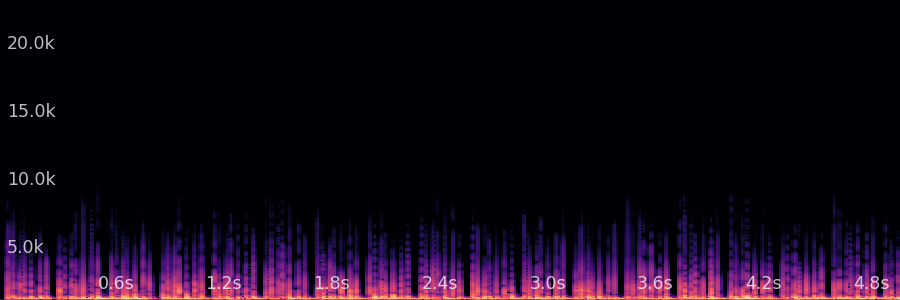
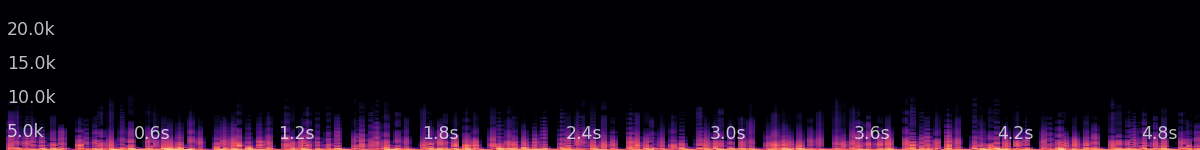

torch.Size([1, 1, 220500])

In [7]:
# AudioSignal docs: https://descriptinc.github.io/audiotools/readme.html
yAudioSig.widget()

yAudioSig.audio_data.shape	

# xsig=xTensor.cpu().detach().numpy()[0,0,:]
# plt.plot(xsig)
# ipd.Audio(xsig, rate=44100)

In [8]:
220500/44100

5.0

### <font color='blue'> Creating a custom dataset 
</font>

In [9]:
class CustomDACDataset(Dataset):
    def __init__(self, data_dir):
        """
        Args:
            data_dir (string): Directory with all the data files.
        """
        self.data_dir = data_dir
        self.file_names = os.listdir(data_dir)

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        fpath = os.path.join(self.data_dir, self.file_names[idx])
        dacfile=dac.DACFile.load(fpath)  # Load the data file
        data = dacfile.codes

        # Assuming data is a tensor of shape [1, N, T]
        # We remove the first dimension to get a tensor of shape [N, T]
        data = data.squeeze(0)

        # The input is the data itself
        input_data = data[:, :-1]  # All time steps except the last one
        # The target is the data shifted by one time step
        target_data = data[:, 1:]  # All time steps except the first one

        # Transpose the last dimensions so we get [T, N] for the transformer
        return input_data.transpose(0, 1), target_data.transpose(0, 1)


In [10]:
# Define the directory where the data files are stored
data_dir = dacdir

# Create an instance of the dataset
dataset = CustomDACDataset(data_dir=data_dir)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Example of iterating over the DataLoader
for batch_idx, (inputs, targets) in enumerate(dataloader):
    pass
    # Your training code here
    # inputs: batch of input data of shape [batch_size, N, T-1]
    # targets: corresponding batch of target data of shape [batch_size, N, T-1]
    
    #print(f"Batch {batch_idx + 1}")
    #print(f"Inputs shape: {inputs.shape}")
    #print(f"Targets shape: {targets.shape}")
print(f"Batch {batch_idx + 1}")

Batch 785
